# Wienerフィルタによるノイズ除去（ハンズオン）

### このセクションの目的
適応信号処理やAI（ブラインド音源分離）に入る前に、**もし、信号とノイズの性質が完全に分かっていたら、どれくらいきれいにノイズを除去できるのか？** という理論的な限界（ゴール）を確認します。

### Wienerフィルタとは？
「信号のパワー」と「ノイズのパワー」の比率に基づいて、**二乗誤差（MSE）を最小化する** 最適な線形フィルタです。
- 信号が強い周波数帯域 → **通す（ゲイン 1.0）**
- ノイズが強い周波数帯域 → **遮断する（ゲイン 0.0）**

というシンプルな原理で動作します。

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile as wav
from IPython.display import Audio, display
import io

# グラフのスタイル設定（見やすくする）
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12

## 1. 信号の生成（Clean Signal）
まずは「除去したい対象」となる、きれいな信号（正解データ）を用意します。
今回は分かりやすく、低い音と高い音が混ざった合成波を作ります。

In [26]:
# --- パラメータ設定 ---
fs = 8000        # サンプリング周波数
duration = 3.0   # 時間(秒)
n_samples = int(fs * duration)
t = np.linspace(0, duration, n_samples, endpoint=False)

# --- 信号の作成 ---
# 440Hz(ラ) と 880Hz(1オクターブ上のラ) の混合
clean_signal = 0.5 * np.sin(2 * np.pi * 440 * t) + 0.3 * np.sin(2 * np.pi * 880 * t)

# 音量調整
clean_signal = clean_signal / np.max(np.abs(clean_signal)) * 0.8

print("正解信号（Clean Signal）を作成しました。")
display(Audio(clean_signal, rate=fs))

正解信号（Clean Signal）を作成しました。


## 2. ノイズの付加（Noisy Input）
現実は甘くありません。通信路や環境音によって、信号には必ずノイズが乗ります。
ここでは、全周波数帯域に広がる「白色雑音（ホワイトノイズ）」を混ぜて、信号を汚します。

観測信号（Noisy Input）を作成しました。かなりうるさいはずです。


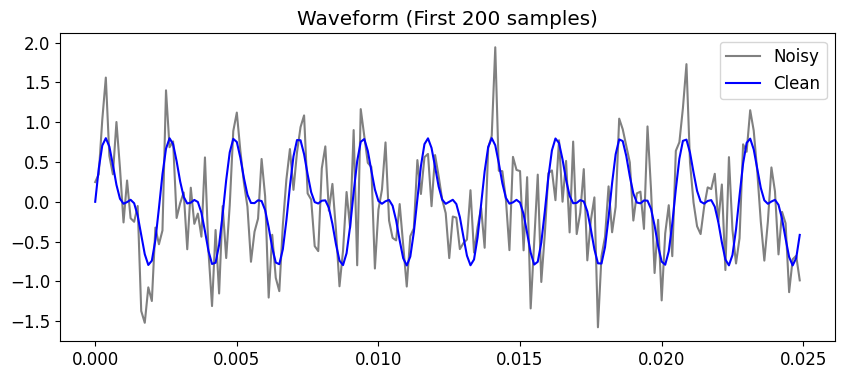

In [27]:
# --- ノイズの生成 ---
np.random.seed(42) # 再現性のためシード固定
noise = 0.5 * np.random.randn(n_samples)

# --- 観測信号（混ぜる） ---
observed_signal = clean_signal + noise

print("観測信号（Noisy Input）を作成しました。かなりうるさいはずです。")
display(Audio(observed_signal, rate=fs))

# 波形確認
plt.figure()
plt.plot(t[:200], observed_signal[:200], color='gray', label='Noisy')
plt.plot(t[:200], clean_signal[:200], color='blue', label='Clean')
plt.title("Waveform (First 200 samples)")
plt.legend()
plt.show()

## 3. スペクトル解析（周波数ごとのパワーを知る）
Wienerフィルタを作るためには、**どの周波数に信号がいて、どの周波数にノイズがいるか** を知る必要があります。

**★ここが最大のポイント（一種のカンニング）★**
本来、手元には「混ざった信号」しかありませんが、ここでは「理想的なフィルタ」を作るために、**あえて「正解信号」と「ノイズ」それぞれのスペクトルを計算**してしまいます。

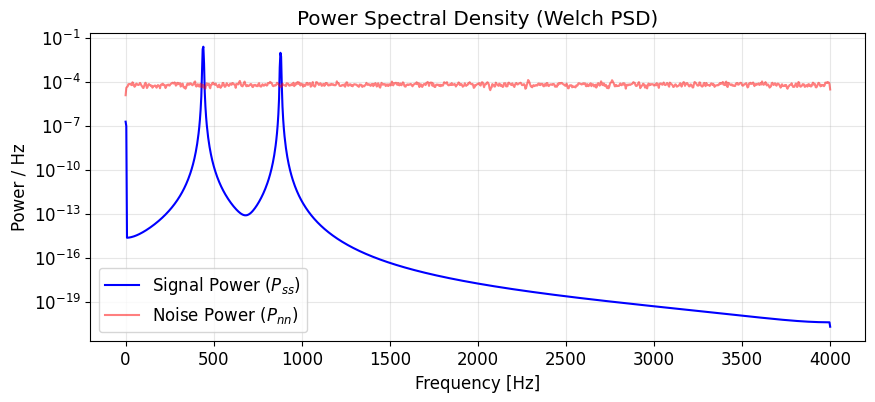

In [28]:
# FFTの設定
N_fft = 2048

# 信号(Signal)のパワースペクトル密度: P_ss
freqs, P_ss = signal.welch(clean_signal, fs, nperseg=N_fft)

# ノイズ(Noise)のパワースペクトル密度: P_nn
freqs, P_nn = signal.welch(noise, fs, nperseg=N_fft)

# スペクトルの表示
plt.figure()
plt.semilogy(freqs, P_ss, label='Signal Power ($P_{ss}$)', color='blue')
plt.semilogy(freqs, P_nn, label='Noise Power ($P_{nn}$)', color='red', alpha=0.5)
plt.title("Power Spectral Density (Welch PSD)")
plt.ylabel("Power / Hz")
plt.xlabel("Frequency [Hz]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4. Wienerフィルタの設計と適用
いよいよフィルタを作ります。Wienerフィルタの式は非常に直感的です。

$$H(f) = \frac{P_{ss}(f)}{P_{ss}(f) + P_{nn}(f)}$$

- **$P_{ss} \gg P_{nn}$ (信号が強い周波数)** $\rightarrow$ $H(f) \approx 1$ （通す）
- **$P_{ss} \ll P_{nn}$ (ノイズが強い周波数)** $\rightarrow$ $H(f) \approx 0$ （消す）

このフィルタ $H(f)$ を、観測信号の周波数成分 $X_{obs}(f)$ に掛け算します。

In [29]:
# --- 1. FFTで周波数領域へ ---
X_obs = np.fft.fft(observed_signal)
freq_bins = np.fft.fftfreq(n_samples, d=1/fs)

# --- 2. フィルタ係数の計算 ---
# 配列サイズを合わせるために補間します
P_ss_interp = np.interp(np.abs(freq_bins), freqs, P_ss)
P_nn_interp = np.interp(np.abs(freq_bins), freqs, P_nn)

# ★ Wienerフィルタの公式 ★
H_wiener = P_ss_interp / (P_ss_interp + P_nn_interp + 1e-10)

# --- 3. フィルタ適用 (周波数領域での掛け算) ---
X_est = X_obs * H_wiener

# --- 4. 時間領域に戻す (IFFT) ---
estimated_signal = np.real(np.fft.ifft(X_est))

print("処理完了。周波数領域でノイズを抑制しました。")

処理完了。周波数領域でノイズを抑制しました。


## 5. 結果の確認
フィルタ形状と、処理結果を確認しましょう。
紫色のグラフがフィルタの形状です。**信号がある440Hzと880Hzだけ山になっていて、他はほぼゼロ** になっていることが分かります。

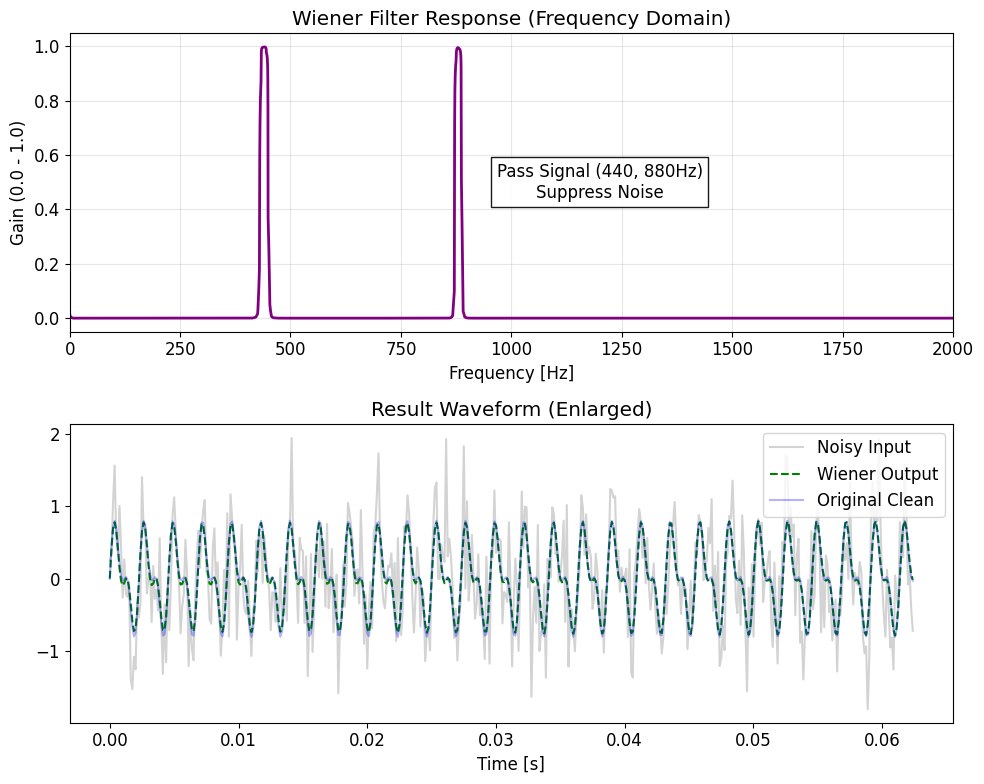

SNR_in=-0.44 dB, SNR_out=21.65 dB, Improvement=22.09 dB
▼ Noisy Input (処理前)


▼ Wiener Output (処理後) - ノイズが消えてクリアになっています


In [30]:
# --- 可視化 ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# 1. Wienerフィルタの振幅特性（正の周波数側）
ax1 = axes[0]

# --- 修正ポイント ---
# fftshift は使わず、「0 Hz 以上（正の周波数側）」だけを抜き出して描画する
pos = freq_bins >= 0
ax1.plot(freq_bins[pos], H_wiener[pos], color='purple', linewidth=2)

ax1.set_title("Wiener Filter Response (Frequency Domain)")
ax1.set_ylabel("Gain (0.0 - 1.0)")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_xlim(0, 2000)  # 表示範囲
ax1.grid(alpha=0.3)

ax1.text(1200, 0.5, "Pass Signal (440, 880Hz)\nSuppress Noise",
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9))

# 2. 波形比較
ax2 = axes[1]
ax2.plot(t[:500], observed_signal[:500], color='lightgray', label='Noisy Input')
ax2.plot(t[:500], estimated_signal[:500], color='green', linestyle='--', linewidth=1.5, label='Wiener Output')
ax2.plot(t[:500], clean_signal[:500], color='blue', alpha=0.3, label='Original Clean')
ax2.set_title("Result Waveform (Enlarged)")
ax2.legend(loc='upper right')
ax2.set_xlabel("Time [s]")

plt.tight_layout()
plt.show()

def snr_db(s, n, eps=1e-12):
    return 10*np.log10((np.mean(s**2)+eps)/(np.mean(n**2)+eps))

snr_in  = snr_db(clean_signal, observed_signal-clean_signal)
snr_out = snr_db(clean_signal, estimated_signal-clean_signal)
print(f"SNR_in={snr_in:.2f} dB, SNR_out={snr_out:.2f} dB, Improvement={snr_out-snr_in:.2f} dB")

# --- 音声再生 ---
print("▼ Noisy Input (処理前)")
display(Audio(observed_signal, rate=fs))

print("▼ Wiener Output (処理後) - ノイズが消えてクリアになっています")
display(Audio(estimated_signal, rate=fs))

## まとめと次への課題

Wienerフィルタは、平均二乗誤差を最小にするという意味で
**理論的に最適な線形フィルタ**です。

実際、通信・音響・画像処理など様々な分野で
現在でも広く利用されています。

ただし、この最適性にはいくつかの前提条件があります。

---

### 現実とのギャップ：どこが難しいのか？

1. **信号とノイズの統計情報が必要**
   - 今回はコード内で `clean_signal` と `noise` を分けて $P_{ss}, P_{nn}$ を計算しました。
   - しかし実際の現場では、観測できるのは
     「混ざった信号 $x = s + n$ 」だけです。
   - 本来は、未知の信号やノイズの統計量をどう推定するかが問題になります。

2. **定常性の仮定**
   - 今回のフィルタは「3秒間の平均スペクトル」を用いて作りました。
   - もし時間とともに環境が変化した場合、
     固定されたフィルタでは十分に対応できないことがあります。

---

### 発展の方向

このような制約を緩めるために発展してきたのが、次の技術です。

- **適応信号処理 (Adaptive Signal Processing)**
  - 統計量を事前に固定せず、
    データに応じてフィルタ係数を逐次更新する方法。

- **ブラインド音源分離 (BSS / ICA)**
  - 信号やノイズの事前情報を仮定せず、
    独立性などの統計的構造から分離を試みる方法。

Wienerフィルタは「理想的条件下での最適解」です。
次は、その理想条件をどう現実に近づけるかを考えていきます。

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>